# (10주차) 5월4일
> 작업환경, softmax, 평가지표, DNN과 fashion MNIST
- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈
- categories : [Bigdata]

---

- 환경  
`-` conda env list : 환경 리스트 확인 (`*`표시가 된 것이 현재 환경)  
`-` conda env remove -n test : test라는 가상 환경 지우기   
`-` conda deactivate : base 환경으로 돌아가기  
`-` conda create -n test : test라는 가상환경을 만들기  
`-` conda activate test : test라는 가상환경에 들어가기  
`-` conda install -c conda-forge jupyterlab : conda는 앱스토어 느낌이라서 꼭 conda를 안해도 된다. 그런데 pip와 차이는 pip는 가장 최신버전을, conda-forge에서 추천하는 조합으로 설치할 수 있다. 그리고 이전에 설치한 패키지도 영향을 받는다.  
`-` conda install -c conda-forge rise : 주피터 노트북을 통해 슬라이드쇼 만들 수 있음!  
`-` slide는  새 슬라이드 만들기, fragment는 상위 슬라이드의 조각, 하나씩 등장

---

### imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.experimental.numpy as tnp

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

---

### 로지스틱 모형 (1): 활성화함수로 sigmoid 선택

`-` 기본버전은 아래와 같다 

$$y_i \approx \text{sigmoid}(b + w_1 x_{1,i} + \dots + w_{784}x_{784,i})= \frac{\exp(b + w_1 x_{1,i} + \dots + w_{784}x_{784,i})}{1+\exp(b + w_1 x_{1,i} + \dots + w_{784}x_{784,i})}$$

`-` 벡터버전은 아래와 같다. 

$${\boldsymbol y} \approx \text{sigmoid}({\bf X}{\bf W} + b) = \frac{\exp({\bf XW} +b)}{1+\exp({\bf XW} +b)}$$ 

`-` 벡터버전에 익숙해지도록 하자. 벡터버전에 사용된 차원 및 연산을 정리하면 아래와 같다. 

- ${\bf X}$: (n,784) matrix 

- ${\boldsymbol y}$: (n,1) matrix

- ${\bf W}$: (784,1) matrix

- $b$: (1,1) matrix

- `+`, `exp` 는 브로드캐스팅

### 로지스틱 모형 (2): 활성화함수로 softmax 선택

`-` softmax는 다차원 범주로 확장하기가 편한다!

`-` $y_i=0 \text{ or } 1$ 대신에 $\boldsymbol{y}_i=[y_{i1},y_{i2}]= [1,0] \text { or } [0,1]$와 같이 코딩하면 어떠할까? (즉 원핫인코딩을 한다면?) 

`-` 활성화 함수를 취하기 전의 버전은 아래와 같이 볼 수 있다. 

$$[{\boldsymbol y}_1 ~ {\boldsymbol y}_2] \propto  [ {\bf X}{\bf W}_1  ~ {\bf X}{\bf W}_2] + [b_1 ~ b_2]= {\bf X} [{\bf W}_1 {\bf W}_2] + [b_1 ~ b_2]= {\bf X}{\bf W} + {\boldsymbol b}$$
    
여기에서 매트릭스 및 연산의 차원을 정리하면 아래와 같다. 

- ${\bf X}$: (n,784) matrix 

- ${\boldsymbol y}_1,{\boldsymbol y}_2$: (n,1) matrix

- ${\boldsymbol y}:=[{\boldsymbol y}_1~ {\boldsymbol y}_2]$: (n,2) matrix

- ${\bf W}_1$, ${\bf W}_2$: (784,1) matrix

- ${\bf W}:=[{\bf W}_1~ {\bf W}_2]$: (784,2) matrix

- $b_1,b_2$: (1,1) matrix

- $\boldsymbol{b}:= [b_1 ~b_2] $: (1,2) matrix

- `+` 는 브로드캐스팅



`-` 즉 로지스틱 모형 (1)의 형태를 **겹쳐놓은** 형태로 해석할 수 있음. 따라서 ${\bf X} {\bf W}_1 + b_1$와 ${\bf X} {\bf W}_2 + b_2$의 row값이 클수록 ${\boldsymbol y}_1$와 ${\boldsymbol y}_2$의 row값이 1이어야 함 

- ${\boldsymbol y}_1 \propto  {\bf X} {\bf W}_1 + b_1$ $\to$ ${\bf X} {\bf W}_1 + b_1$의 row값이 클수록 $\boldsymbol{y}_1$의 row 값이 1이라면 모형계수를 잘 추정한것 
- ${\boldsymbol y}_2 \propto  {\bf X} {\bf W}_2 + b_2$ $\to$ ${\bf X} {\bf W}_2 + b_2$의 row값이 클수록 $\boldsymbol{y}_2$의 row 값을 1이라면 모형계수를 잘 추정한것


`-` (문제) ${\bf X}{\bf W}_1 +b_1$의 값이 500, ${\bf X}{\bf W}_2 +b_2$의 값이 200 인 row가 있다고 하자. 대응하는 $\boldsymbol{y}_1, \boldsymbol{y}_2$의 row값은 얼마로 적합되어야 하는가? 

(1) $[0,0]$

(2) $[0,1]$

(3) $[1,0]$ <-- 이게 답이다!

(4) $[1,1]$

> solution: 둘다 0 혹은 둘다 1로 적합할수는 없으니까 (1), (4)는 제외한다. ${\bf X}{\bf W}_1 +b_1$의 값이 ${\bf X}{\bf W}_2 +b_2$의 값보다 크므로 (3)번이 합리적임 

`-` **목표:** 위와 같은 문제의 답을 유도해주는 활성화함수를 설계하자. 즉 합리적인 $\hat{\boldsymbol{y}}_1,\hat{\boldsymbol{y}}_2$를 구해주는 활성화 함수를 설계해보자. 이를 위해서는 아래의 사항들이 충족되어야 한다. 

(1) $\hat{\boldsymbol{y}}_1$, $\hat{\boldsymbol{y}}_2$의 각 원소는 0보다 크고 1보다 작아야 한다. (확률을 의미해야 하니까)

(2) $\hat{\boldsymbol{y}}_1+\hat{\boldsymbol{y}}_2={\bf 1}$ 이어야 한다. (확률의 총합은 1이니까!)

(3) $\hat{\boldsymbol{y}}_1$와 $\hat{\boldsymbol{y}}_2$를 각각 따로해석하면 로지스틱처럼 되면 좋겠다. 

`-` 아래와 같은 활성화 함수를 도입하면 어떨까? 

$$\hat{\boldsymbol{y}}=[\hat{\boldsymbol y}_1 ~ \hat{\boldsymbol y}_2] =  \big[ \frac{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)}{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)+\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}  ~~ \frac{\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)+\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}  \big]$$ 

`-` (1),(2)는 만족하는 듯 하다. (3)은 바로 이해되지는 않는다

(1) $\hat{\boldsymbol{y}}_1$, $\hat{\boldsymbol{y}}_2$의 각 원소는 0보다 크고 1보다 작아야 한다. --> OK!

(2) $\hat{\boldsymbol{y}}_1+\hat{\boldsymbol{y}}_2={\bf 1}$ 이어야 한다. --> OK!

(3) $\hat{\boldsymbol{y}}_1$와 $\hat{\boldsymbol{y}}_2$를 각각 따로해석하면 로지스틱처럼 되면 좋겠다.  --> ??? 

`-` 그런데 조금 따져보면 (3)도 만족된다는 것을 알 수 있다. (sigmoid, softmax Section 참고)

`-` 위와 같은 함수를 softmax라고 하자. 즉 아래와 같이 정의하자. 

$$
\hat{\boldsymbol y} = \text{softmax}({\bf X}\hat{\bf W} + {\boldsymbol b}) 
= \big[ \frac{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)}{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)+\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}  ~~ \frac{\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)+\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}  \big]
$$

---

### sigmoid, softmax 

#### **softmax는 sigmoid의 확장형**

`-` 아래의 수식을 관찰하자. 
$$\frac{\exp(\beta_0+\beta_1 x_i)}{1+\exp(\beta_0+\beta_1x_i)}=\frac{\exp(\beta_0+\beta_1 x_i)}{e^0+\exp(\beta_0+\beta_1x_i)}$$

`-` 1을 $e^0$로 해석하면 모형2의 해석을 아래와 같이 모형1의 해석으로 적용할수 있다. 
- 모형2: ${\bf X}\hat{\bf W}_1 +\hat{b}_1$ 와 ${\bf X}\hat{\bf W}_2 +\hat{b}_2$ 의 크기를 비교하고 확률 결정
- 모형1: ${\bf X}\hat{\bf W} +\hat{b}$ 와 $0$의 크기를 비교하고 확률 결정 = **${\bf X}\hat{\bf W} +\hat{b}$의 row값이 양수이면 1로 예측하고 음수이면 0으로 예측**

`-` 이항분포를 차원이 2인 다항분포로 해석가능한 것처럼 sigmoid는 차원이 2인 softmax로 해석가능하다. 즉 다항분포가 이항분포의 확장형으로 해석가능한 것처럼 softmax도 sigmoid의 확장형으로 해석가능하다. 

#### **클래스의 수가 2인 경우 softmax vs sigmoid**

`-` 언뜻 생각하면 클래스가 2인 경우에도 sigmoid 대신 softmax로 활성화함수를 이용해도 될 듯 하다. 즉 $y=0 \text{ or } 1$와 같이 정리하지 않고 $y=[0,1] \text{ or } [1,0]$ 와 같이 정리해도 무방할 듯 하다. 

`-` **하지만 sigmoid가 좀 더 좋은 선택이다.** 즉 $y= 0 \text{ or } 1$로 데이터를 정리하는 것이 더 좋은 선택이다. 왜냐하면 sigmoid는 softmax와 비교하여 파라메터의 수가 적지만 표현력은 동등하기 때문이다. 

`-` 표현력이 동등한 이유? 아래 수식을 관찰하자. 

$$\big(\frac{e^{300}}{e^{300}+e^{500}},\frac{e^{500}}{e^{300}+e^{500}}\big) =\big( \frac{e^{0}}{e^{0}+e^{200}}, \frac{e^{200}}{e^{0}+e^{200}}\big)$$

- $\big(\frac{e^{300}}{e^{300}+e^{500}},\frac{e^{500}}{e^{300}+e^{500}}\big)$를 표현하기 위해서 300, 500 이라는 2개의 숫자가 필요한것이 아니고 따지고보면 **200이라는 하나의 숫자만 필요하다.** 
- $(\hat{\boldsymbol{y}}_1,\hat{\boldsymbol{y}}_2)$의 표현에서도 ${\bf X}\hat{\bf W}_1 +\hat{b}_1$ 와 ${\bf X}\hat{\bf W}_2 +\hat{b}_2$ 라는 숫자 각각이 필요한 것이 아니고 $({\bf X}\hat{\bf W}_1 +\hat{b}_1)-({\bf X}\hat{\bf W}_2 +\hat{b}_2)$의 값만 알면 된다. 

`-` 클래스의 수가 2개일 경우는 softmax가 sigmoid에 비하여 장점이 없다. 하지만 softmax는 클래스의 수가 3개 이상일 경우로 쉽게 확장할 수 있다는 점에서 매력적인 활성화 함수이다. 

### 분류할 클래스가 3개 이상일 경우 신경망 모형의 설계 

`-` y의 모양: [0 1 0 0 0 0 0 0 0 0] 

`-` 활성화함수의 선택: softmax 

`-` 손실함수의 선택: cross entropy

### Fashion_MNIST 다중분류 

`-` 데이터정리 

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [20]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [19]:
tf.keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
X=x_train.reshape(-1,784)
y=tf.keras.utils.to_categorical(y_train)
XX=x_test.reshape(-1,784)
yy=tf.keras.utils.to_categorical(y_test)

`-` 시도1: 간단한 신경망

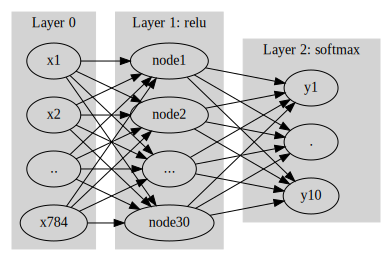

In [8]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;

    "node1" -> "y10"
    "node2" -> "y10"
    "..." -> "y10"
    "node30" -> "y10"
    
    "node1" -> "y1"
    "node2" -> "y1"
    "..." -> "y1"
    "node30" -> "y1"
    
    "node1" -> "."
    "node2" -> "."
    "..." -> "."
    "node30" -> "."
    
    label = "Layer 2: softmax"
}
''')

In [21]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(10,activation='softmax'))
net.compile(optimizer='adam',loss=tf.losses.categorical_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 18s 10ms/step - loss: 2.5281 - accuracy: 0.4108
Epoch 2/5
1875/1875 [==============================] - 18s 10ms/step - loss: 1.2369 - accuracy: 0.4949
Epoch 3/5
1875/1875 [==============================] - 18s 10ms/step - loss: 1.1364 - accuracy: 0.5316
Epoch 4/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.9777 - accuracy: 0.6145
Epoch 5/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.8753 - accuracy: 0.6385


In [22]:
net.evaluate(XX,yy)

313/313 [==============================] - 4s 12ms/step - loss: 0.8944 - accuracy: 0.6563


[0.894415020942688, 0.6563000082969666]

`-` 시도2: 더 깊은 신경망 

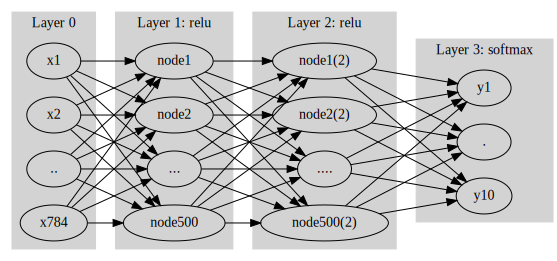

In [23]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node500"
    "x2" -> "node500"
    ".." -> "node500"
    "x784" -> "node500"


    label = "Layer 1: relu"
}

subgraph cluster_3{
    style=filled;
    color=lightgrey;

    "node1" -> "node1(2)"
    "node2" -> "node1(2)"
    "..." -> "node1(2)"
    "node500" -> "node1(2)"

    "node1" -> "node2(2)"
    "node2" -> "node2(2)"
    "..." -> "node2(2)"
    "node500" -> "node2(2)"
    
    "node1" -> "...."
    "node2" -> "...."
    "..." -> "...."
    "node500" -> "...."
    
    "node1" -> "node500(2)"
    "node2" -> "node500(2)"
    "..." -> "node500(2)"
    "node500" -> "node500(2)"

    
    label = "Layer 2: relu"
}

subgraph cluster_4{
    style=filled;
    color=lightgrey;

    "node1(2)" -> "y10"
    "node2(2)" -> "y10"
    "...." -> "y10"
    "node500(2)" -> "y10"
    
    "node1(2)" -> "y1"
    "node2(2)" -> "y1"
    "...." -> "y1"
    "node500(2)" -> "y1"
    
    "node1(2)" -> "."
    "node2(2)" -> "."
    "...." -> "."
    "node500(2)" -> "."
    
    label = "Layer 3: softmax"
}
''')

In [24]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(500,activation='relu'))
net.add(tf.keras.layers.Dense(500,activation='relu'))
net.add(tf.keras.layers.Dense(10,activation='softmax'))
net.compile(optimizer='adam',loss=tf.losses.categorical_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 18s 10ms/step - loss: 2.2519 - accuracy: 0.7419
Epoch 2/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.6466 - accuracy: 0.7918
Epoch 3/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.5628 - accuracy: 0.8116
Epoch 4/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4696 - accuracy: 0.8359
Epoch 5/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4355 - accuracy: 0.8469


In [25]:
net.evaluate(XX,yy)

313/313 [==============================] - 4s 12ms/step - loss: 0.4929 - accuracy: 0.8289


[0.4929366707801819, 0.8288999795913696]

In [28]:
net.summary()  #사용한 파라미터 수 확인 : 648010

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 500)               392500    
                                                                 
 dense_5 (Dense)             (None, 500)               250500    
                                                                 
 dense_6 (Dense)             (None, 10)                5010      
                                                                 
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


- accuracy는 두번째 네트워크가 더 좋지만 파라미터가 좀 낭비되었다고 생각할 수도 있겠다..

---

## 평가지표

### 다양한 평가지표들 

`-` 의문: 왜 다양한 평가지표가 필요한가? (accuracy면 끝나는거 아닌가? 더 이상 뭐가 필요해?)

`-` 여러가지 평가지표들: https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values
- 이걸 다 암기하는건 불가능함. 
- 몇 개만 뽑아서 암기하고 왜 쓰는지만 생각해보고 넘어가자!

### confusion matrix의 이해 

`-` 표1

| |퇴사(예측)|안나감(예측)|
|:-:|:-:|:-:|
|퇴사(실제)|TP|FN|
|안나감(실제)| FP| TN|

`-` 표2 (책에없음) 

| |퇴사(예측)|안나감(예측)|
|:-:|:-:|:-:|
|퇴사(실제)|$(y,\hat{y})= $ (O,O)|$(y,\hat{y})= $(O,X)|
|안나감(실제)| $(y,\hat{y})= $(X,O)| $(y,\hat{y})= $(X,X)|

`-` 표3 (책에없음) 

| |퇴사(예측)|안나감(예측)|
|:-:|:-:|:-:|
|퇴사(실제)|TP, $\# O/O$ |FN, $\#O/X$|
|안나감(실제)| FP, $\#X/O$| TN, $\#X/X$|

- 암기법, (1) 두번째 글자를 그대로 쓴다 (2) 첫글자가 T이면 분류를 제대로한것, 첫글자가 F이면 분류를 잘못한것

`-` 표4 (위키등에 있음) 

| |퇴사(예측)|안나감(예측)| |
|:-:|:-:|:-:|:-:|
|퇴사(실제)| TP, $\# O/O$ |FN, $\# O/X$| Sensitivity(민감도)=Recall(재현율)=$\frac{TP}{TP+FN}$=$\frac{\#O/O}{\# O/O+ \#O/X}$|
|안나감(실제)| FP, $\# X/O$| TN, $\# X/X$| |
| |Precision(프리시즌,정밀도)=$\frac{TP}{TP+FP}$=$\frac{\# O/O}{\# O/O+\# X/O}$| |Accuracy(애큐러시,정확도)=$\frac{TP+TN}{total}$=$\frac{\#O/O+\# X/X}{total}$|

### 상황극 

`-` 최규빈은 입사하여 "퇴사자 예측시스템"의 개발에 들어갔다. 

`-` 자료의 특성상 대부분의 사람이 퇴사하지 않고 회사에 잘 다닌다. 즉 1000명이 있으면 10명정도 퇴사한다. 

### Accuracy

`-` 정의: Accuracy(애큐러시)=$\frac{TP+TN}{total}$=$\frac{\#O/O+ \#X/X}{total}$
- 한국말로는 정확도, 정분류율이라고 한다. 
- 한국말이 헷갈리므로 그냥 영어를 외우는게 좋다. (어차피 Keras에서 옵션도 영어로 넣음) 

`-` (상확극 시점1) 왜 애큐러시는 불충분한가?
- 회사: 퇴사자예측프로그램 개발해
- 최규빈: 귀찮은데 다 안 나간다고 하자! -> 99퍼의 accuracy 

> 모델에 사용한 파라메터 = 0. 그런데 애큐러시 = .99! 이거 엄청 좋은 모형이다? 


### Sensitivity(민감도), Recall(재현율), True Positive Rate(TPR)

`-` 정의: Sensitivity(민감도)=Recall(재현율)=$\frac{TP}{TP+FN}$=$\frac{\# O/O}{\# O/O+\# O/X}$
- 분모: 실제 O인 관측치 수 
- 분자: 실제 O를 O라고 예측한 관측치 수 
- 뜻: 실제 O를 O라고 예측한 비율

`-` (상황극 시점2) recall을 봐야하는 이유
- 인사팀: 실제 퇴사자를 퇴사자로 예측해야 의미가 있음! 우리는 퇴사할것 같은 10명을 찍어달란 의미였어요! (그래야 면담을 하든 할거아냐!) 
- 최규빈: 가볍고(=파라메터 적고) 잘 맞추는 모형 만들어 달라면서요?


- 인사팀: (고민중..) 사실 생각해보니까 이 경우는 애큐러시는 의미가 없네. 실제 나간 사람 중 최규빈이 나간다고 한 사람이 몇인지 카운트 하는게 더 의미가 있겠다. 우리는 앞으로 리컬(혹은 민감도)를 보겠다! 

> 예시1: 실제로 퇴사한 10명중 최규빈이 나간다고 찍은 사람이 5명이면 리컬이 50% 

> 예시2: 최규빈이 아무도 나가지 않는다고 예측해버린다? 실제 10명중에서 최규빈이 나간다고 적중시킨사람은 0명이므로 이 경우 리컬은 0%

- 결론: 우리가 필요한건 recall이니까 앞으로 recall을 가져와! accuracy는 큰 의미없어. (그래도 명색이 모델인데 accuracy가 90은 되면 좋겠다)

### Precision

`-` 정의: Precision(프리시즌)=$\frac{TP}{TP+FP}$=$\frac{\# O/O}{\# O/O+\# X/O}$
- 분모: O라고 예측한 관측치
- 분자: O라고 예측한 관측치중 진짜 O인 관측치 
- 뜻: O라고 예측한 관측치중 진짜 O인 비율

`-` (상황극 시점3) recall 만으로 불충분한 이유

- 최규빈: 에휴.. 귀찮은데 그냥 좀만 수틀리면 다 나갈것 같다고 해야겠다. cut value를 낮게 잡아야징 -> 한 100명 나간다고 했음 -> 실제로 최규빈이 찍은 100명중에 10명이 다 나감!

> 이 경우 애큐러시는 91%, 리컬은 100% (퇴사자 10명을 일단은 다 맞췄으므로). 

- 인사팀: (화가 많이 남) 멀쩡한 사람까지 다 퇴사할 것 같다고 하면 어떡해요? 최규빈 연구원이 나간다고 한 100명중에 실제로 10명만 나갔어요. 

- 인사팀: 마치 총으로 과녁중앙에 맞춰 달라고 했더니 기관총을 가져와서 한번 긁은것이랑 뭐가 달라요? 맞추는게 문제가 아니고 precision이 너무 낮아요. 

- 최규빈: accuracy 90% 이상, recall은 높을수록 좋다는게 주문 아니었나요? 

- 인사팀: (고민중..) 앞으로는 recall과 함께 precision도 같이 제출하세요. precision은 당신이 나간다고 한 사람중에 실제 나간사람의 비율을 의미해요. 이 경우는 $\frac{10}{100}$이니까 precision이 10%입니다. (속마음: recall 올리겠다고 무작정 너무 많이 예측하지 말란 말이야!) 

### F1 score 

`-` 정의: recall과 precision의 조화평균 

`-` (상황극 시점4) recall, precision을 모두 고려 

- 최규빈: recall/precision을 같이 내는건 좋은데요, 둘은 trade off의 관계에 있습니다. 물론 둘다 올리는 모형이 있다면 좋지만 그게 쉽지는 않아요. 보통은 precision을 올리려면 recall이 희생되는 면이 있고요, recall을 올리려고 하면 precision이 다소 떨어집니다. 

- 최규빈: 평가기준이 애매하다는 의미입니다. 모형1,2가 있는데 모형1은 모형2보다 precision이 약간 좋고 대신 recall이 떨어진다면 모형1이 좋은것입니까? 아니면 모형2가 좋은것입니까? 

- 인사팀: 그렇다면 둘을 평균내서 F1score를 계산해서 제출해주세요. 

### Specificity(특이도), False Positive Rate(FPR) 

`-` 정의: 

(1) Specificity(특이도)=$\frac{TN}{FP+TN}$=$\frac{\# X/X}{\# X/O+\# X/X}$

(2) False Positive Rate (FPR) = 1-Specificity(특이도) = $\frac{FP}{FP+TN}$=$\frac{\# X/O}{\# X/O+\# X/X}$

`-` 의미: **FPR = 오해해서 미안해, recall(=TPR)을 올리려고 보니 어쩔 수 없었어 ㅠㅠ**
- specificity는 안나간 사람을 안나갔다고 찾아낸 비율인데 별로 안중요하다. 
- FPR은 recall을 올리기 위해서 "실제로는 회사 잘 다니고 있는 사람 중 최규빈이 나갈것 같다고 찍은 사람들" 의 비율이다. 

> 즉 생사람잡은 비율.. 오해해서 미안한 사람의 비율.. 

### ROC curve 

`-` 정의: $x$축=FPR, $y$축=TPR 을 그린 커브 

`-` 의미: 
- 결국 "오해해서 미안해 vs recall"을 그린 곡선이 ROC커브이다. 
- 생각해보면 오해하는 사람이 많을수록 당연히 recall은 올라간다. 따라서 우상향하는 곡선이다. 
- 오해한 사람이 매우 적은데 recall이 우수하면 매우 좋은 모형이다. 그래서 초반부터 ROC값이 급격하게 올라가면 좋은 모형이다. 

---

## fashion_mnist (revisit)

In [29]:
import tensorflow as tf 
import tensorflow.experimental.numpy as tnp

In [30]:
tnp.experimental_enable_numpy_behavior()

In [31]:
import matplotlib.pyplot as plt

`-` fashion mnist data 다시 불러오자 

In [32]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [33]:
x_train.shape

(60000, 28, 28)

- 이미지는 원래 가로픽셀 * 세로픽셀 * 3 이어야 한다. (색을 표현하는 basis는 빨,녹,파)

`-` 따라서 이미지의 차원이 단지 (28,28)이라는 것은 흑백이미지라는 뜻이다. 

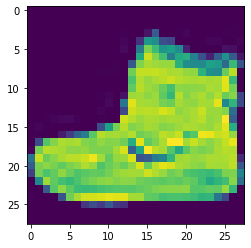

In [74]:
plt.imshow(x_train[0]) 

- 아닌데요?! 칼라인데요?! -> 흑백이다. 그냥 밝을수록 노란색, 어두울수록 남색으로 표현한것 뿐임 (colormap이 viridis일 뿐임)

`-` 일반적으로 분석할 이미지는 칼라를 의미하는 채널도 포함할테니 아래와 같이 자료형을 정리하는게 일반적으로 이미지 자료를 분석하는 정석적인 처리방법이다. 

`-` 그런데 모형에 넣고 돌릴려면 다시 차원을 펼쳐야 하지 않을까?

`-` 안 펼치고 할 수 없나? $\to$ 아래의 `flatten`

In [35]:
X = tf.constant(x_train.reshape(-1,28,28,1),dtype=tf.float64)
y = tf.keras.utils.to_categorical(y_train)
XX = tf.constant(x_test.reshape(-1,28,28,1),dtype=tf.float64)
yy = tf.keras.utils.to_categorical(y_test)

In [36]:
X.shape, XX.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

- keras에서 이미지자료는 (관측치수,픽셀,픽셀,채널)과 같은 형식을 가진다. 
- 예를들어 256*256 size인 칼라이미지(채널수=3)가 10개 있다면 X.shape은 (10,256,256,3)이다. 

## X의 차원이 (관측치수,픽셀,픽셀,채널)일 경우 DNN 쓰기 

### (예제1) X -> Dense(30,relu) -> Dense(10,softmax):=> y 

`-` 이러한 아키텍처를 돌리기 위해서는 X의 shape을 미리 바꿔야 했었다. 혹시 바꾸지 않는 방법도 있을까? 

`-` tf.keras.layers.Flatten()

In [37]:
flttn = tf.keras.layers.Flatten()

In [38]:
flttn

- type: flatten <- 머 어쩌란거야..

In [72]:
set(dir(flttn)) & {'__call__'}  #set으로 집합, &으로 교집합

{'__call__'}

- call이 있음 -> 써보자

In [75]:
X.shape, flttn(X)

(TensorShape([60000, 28, 28, 1]),
 <tf.Tensor: shape=(60000, 784), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)

In [76]:
flttn(X)

<tf.Tensor: shape=(60000, 784), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [77]:
X.reshape(-1,784)

<tf.Tensor: shape=(60000, 784), dtype=float64, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])>

펴진다? **즉 X.reshape(-1,784)와 같은 기능!**

`-` 근데 이거 **레이어다?** **즉 네트워크에 add 할 수 있다는 의미!**

`-` 그렇다면 아래와 같이 예제를 풀어도 괜찮겠다.
> metrics=['accuracy','Recall']이렇게 2개도 가능하지!

In [42]:
tf.random.set_seed(43052)
net1 = tf.keras.Sequential()
net1.add(tf.keras.layers.Flatten())
net1.add(tf.keras.layers.Dense(30,activation='relu'))
net1.add(tf.keras.layers.Dense(10,activation='softmax'))
net1.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])
net1.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 19s 10ms/step - loss: 2.5291 - accuracy: 0.4090
Epoch 2/5
1875/1875 [==============================] - 19s 10ms/step - loss: 1.1649 - accuracy: 0.5447
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.9883 - accuracy: 0.5980
Epoch 4/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.9369 - accuracy: 0.6159
Epoch 5/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.8640 - accuracy: 0.6451


`-` 관찰

In [43]:
net1.layers

In [44]:
net1.layers[0](X) # 레이어를 통과하는 순간 전처리!

<tf.Tensor: shape=(60000, 784), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [45]:
net1.layers[1](net1.layers[0](X)) # 출력이 30이니까~ + 렐루를 거쳐서 0또는 양수인 모습!

<tf.Tensor: shape=(60000, 30), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [46]:
net1.layers[2](net1.layers[1](net1.layers[0](X))) # 최종출력 10차원, 각각은 확률을 의미하게 된다. 

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0529677e-04,
        0.0000000e+00, 9.9789065e-01],
       [1.3276602e-01, 1.8076894e-03, 2.3582792e-01, ..., 2.4486837e-04,
        2.6956499e-02, 7.0856529e-04],
       [4.4846085e-01, 2.3028793e-02, 1.6645418e-03, ..., 5.9820746e-24,
        8.2463684e-04, 7.2763857e-14],
       ...,
       [4.6494240e-01, 6.1101977e-02, 2.1869731e-05, ..., 3.4271203e-38,
        3.0596584e-05, 2.7073474e-21],
       [1.7478003e-01, 2.7406293e-03, 1.6104330e-01, ..., 2.3228845e-06,
        2.1515733e-02, 7.0975919e-05],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.1029420e-09,
        1.7662206e-26, 2.8550520e-10]], dtype=float32)>

`-` (참고) metrics=['accuracy'] 대신에 이렇게 해도된다~

In [47]:
tf.random.set_seed(43052)
net1 = tf.keras.Sequential()
net1.add(tf.keras.layers.Flatten())
net1.add(tf.keras.layers.Dense(30,activation='relu'))
net1.add(tf.keras.layers.Dense(10,activation='softmax'))
net1.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=[tf.metrics.CategoricalAccuracy()])
net1.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 19s 10ms/step - loss: 2.5211 - categorical_accuracy: 0.4120
Epoch 2/5
1875/1875 [==============================] - 19s 10ms/step - loss: 1.1434 - categorical_accuracy: 0.5489
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 1.0170 - categorical_accuracy: 0.5913
Epoch 4/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.9324 - categorical_accuracy: 0.6153
Epoch 5/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.8899 - categorical_accuracy: 0.6336


In [48]:
id(tf.metrics.CategoricalAccuracy), id(tf.keras.metrics.CategoricalAccuracy)

(93847881526656, 93847881526656)

- 주소가 똑같네요, 이게 무슨말인지 알죠?

`-` 주의사항: tf.metrics.Accuracy() 말고 tf.metrics.CategoricalAccuracy() 를 써야함

`-` (참고2) 메트릭을 추가할수도 있다 

In [49]:
tf.random.set_seed(43052)
net1 = tf.keras.Sequential()
net1.add(tf.keras.layers.Flatten())
net1.add(tf.keras.layers.Dense(30,activation='relu'))
net1.add(tf.keras.layers.Dense(10,activation='softmax'))
net1.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=[tf.metrics.CategoricalAccuracy(),tf.metrics.Recall()])
net1.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 18s 10ms/step - loss: 2.5215 - categorical_accuracy: 0.4158 - recall: 0.3054
Epoch 2/5
1875/1875 [==============================] - 18s 10ms/step - loss: 1.1357 - categorical_accuracy: 0.5554 - recall: 0.4457
Epoch 3/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.9923 - categorical_accuracy: 0.5962 - recall: 0.4853
Epoch 4/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.9309 - categorical_accuracy: 0.6177 - recall: 0.5026
Epoch 5/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.8677 - categorical_accuracy: 0.6448 - recall: 0.4892


`-` 리콜을 추가하면 test set의 성능평가에도 리콜을 볼 수 있다.

In [50]:
net1.evaluate(XX,yy)

313/313 [==============================] - 4s 13ms/step - loss: 0.8814 - categorical_accuracy: 0.6443 - recall: 0.5028


[0.8814178705215454, 0.6442999839782715, 0.5027999877929688]

### (예제2) X -> Dense(500,relu) -> Dense(500,relu) -> Dense(10,softmax):=>y 

`-` 다른모형으로도 적합시켜보자. 

In [51]:
tf.random.set_seed(43052)
net2 = tf.keras.Sequential()
net2.add(tf.keras.layers.Flatten())
net2.add(tf.keras.layers.Dense(500,activation='relu'))
net2.add(tf.keras.layers.Dense(500,activation='relu'))
net2.add(tf.keras.layers.Dense(10,activation='softmax'))
net2.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])
net2.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 18s 10ms/step - loss: 2.2255 - accuracy: 0.7517
Epoch 2/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.6271 - accuracy: 0.7969
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.5380 - accuracy: 0.8176
Epoch 4/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4652 - accuracy: 0.8351
Epoch 5/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4367 - accuracy: 0.8450


In [52]:
net2.fit(XX,yy)

313/313 [==============================] - 4s 12ms/step - loss: 0.4871 - accuracy: 0.8318


In [79]:
net1.summary()
net2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_11 (Dense)            (None, 30)                23550     
                                                                 
 dense_12 (Dense)            (None, 10)                310       
                                                                 
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)           

`-` 좀 더 돌려보자. 

In [53]:
tf.random.set_seed(43052)
net2 = tf.keras.Sequential()
net2.add(tf.keras.layers.Flatten())
net2.add(tf.keras.layers.Dense(500,activation='relu'))
net2.add(tf.keras.layers.Dense(500,activation='relu'))
net2.add(tf.keras.layers.Dense(10,activation='softmax'))
net2.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])
net2.fit(X,y,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 18s 10ms/step - loss: 2.2612 - accuracy: 0.7479
Epoch 2/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.6076 - accuracy: 0.7995
Epoch 3/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.5334 - accuracy: 0.8198
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4587 - accuracy: 0.8380
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4279 - accuracy: 0.8475
Epoch 6/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.4102 - accuracy: 0.8527
Epoch 7/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3999 - accuracy: 0.8605
Epoch 8/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3851 - accuracy: 0.8611
Epoch 9/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3825 - accuracy: 0.8623
Epoch 10/10
1875/1875 [==============================] - 19s 10m

In [54]:
net2.fit(XX,yy)

313/313 [==============================] - 4s 12ms/step - loss: 0.4468 - accuracy: 0.8489


`-` 이 이상은 비효율적인듯.. 

## 더 좋은 모형을 만들고 싶은데.. 

### (예제3) 아주 복잡한 DNN

`-` 무지성: 아 몰라 딥러닝이 해주겠지

In [55]:
tf.random.set_seed(43052)
net3 = tf.keras.Sequential()
net3.add(tf.keras.layers.Flatten())
net3.add(tf.keras.layers.Dense(500,activation='relu'))
net3.add(tf.keras.layers.Dense(500,activation='relu'))
net3.add(tf.keras.layers.Dense(500,activation='relu'))
net3.add(tf.keras.layers.Dense(500,activation='relu'))
net3.add(tf.keras.layers.Dense(500,activation='relu'))
net3.add(tf.keras.layers.Dense(10,activation='softmax'))
net3.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])
net3.fit(X,y,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.9836 - accuracy: 0.7942
Epoch 2/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.4495 - accuracy: 0.8395
Epoch 3/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.4185 - accuracy: 0.8528
Epoch 4/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.3930 - accuracy: 0.8619
Epoch 5/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.3736 - accuracy: 0.8686
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.3683 - accuracy: 0.8718
Epoch 7/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.3445 - accuracy: 0.8774
Epoch 8/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.3325 - accuracy: 0.8816
Epoch 9/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.3288 - accuracy: 0.8829
Epoch 10/10
1875/1875 [==============================] - 16s 8ms/step - l

In [56]:
net3.evaluate(XX,yy)

313/313 [==============================] - 4s 12ms/step - loss: 0.3723 - accuracy: 0.8702


[0.372260183095932, 0.870199978351593]

In [57]:
net2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_16 (Dense)            (None, 500)               392500    
                                                                 
 dense_17 (Dense)            (None, 500)               250500    
                                                                 
 dense_18 (Dense)            (None, 10)                5010      
                                                                 
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


In [58]:
net3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 500)               392500    
                                                                 
 dense_20 (Dense)            (None, 500)               250500    
                                                                 
 dense_21 (Dense)            (None, 500)               250500    
                                                                 
 dense_22 (Dense)            (None, 500)               250500    
                                                                 
 dense_23 (Dense)            (None, 500)               250500    
                                                                 
 dense_24 (Dense)            (None, 10)               

`-` 파라메터 증가대비 그닥.. 

`-` 왠지 DNN계열로는 한계가 있어보인다. 

###### $\to$ 여기까지 05/09 수업내용

---

### 발상의 전환 

`-` Flattne 레이어를 보면서 느낀점: 생각해보니까 $X \to \hat{y}$를 만드는 과정이 꼭 Full Linear Transform(Dense layer) + Activation(Activation layer)일 필요는 없잖아?  

`-` 뭐가있지? 

In [59]:
dir(tf.keras.layers)

['AbstractRNNCell',
 'Activation',
 'ActivityRegularization',
 'Add',
 'AdditiveAttention',
 'AlphaDropout',
 'Attention',
 'Average',
 'AveragePooling1D',
 'AveragePooling2D',
 'AveragePooling3D',
 'AvgPool1D',
 'AvgPool2D',
 'AvgPool3D',
 'BatchNormalization',
 'Bidirectional',
 'CategoryEncoding',
 'CenterCrop',
 'Concatenate',
 'Conv1D',
 'Conv1DTranspose',
 'Conv2D',
 'Conv2DTranspose',
 'Conv3D',
 'Conv3DTranspose',
 'ConvLSTM1D',
 'ConvLSTM2D',
 'ConvLSTM3D',
 'Convolution1D',
 'Convolution1DTranspose',
 'Convolution2D',
 'Convolution2DTranspose',
 'Convolution3D',
 'Convolution3DTranspose',
 'Cropping1D',
 'Cropping2D',
 'Cropping3D',
 'Dense',
 'DenseFeatures',
 'DepthwiseConv1D',
 'DepthwiseConv2D',
 'Discretization',
 'Dot',
 'Dropout',
 'ELU',
 'Embedding',
 'Flatten',
 'GRU',
 'GRUCell',
 'GaussianDropout',
 'GaussianNoise',
 'GlobalAveragePooling1D',
 'GlobalAveragePooling2D',
 'GlobalAveragePooling3D',
 'GlobalAvgPool1D',
 'GlobalAvgPool2D',
 'GlobalAvgPool3D',
 'GlobalM

`-` 엄청많아.. 

`-` 우리는 이중에서 2D conv, max pooling 에 관심이 있다! (이번수업은 max pooling 정도만)

#### MaxPooling2D, MaxPool2D

In [60]:
id(tf.keras.layers.MaxPooling2D), id(tf.keras.layers.MaxPool2D)

(93847880576320, 93847880576320)

`-` 테스트1: (2,2) 이미지

In [61]:
mp = tf.keras.layers.MaxPool2D() # pool size의 디폴트는 (2,2)

In [62]:
XXX = tnp.arange(1*2*2*1).reshape(1,2,2,1)
XXX

<tf.Tensor: shape=(1, 2, 2, 1), dtype=int64, numpy=
array([[[[0],
         [1]],

        [[2],
         [3]]]])>

In [63]:
XXX.reshape(1,2,2) # 채널때문에 살짝 헷갈리지만 실제로는 이렇게 생긴 이미지! 

<tf.Tensor: shape=(1, 2, 2), dtype=int64, numpy=
array([[[0, 1],
        [2, 3]]])>

In [64]:
mp(XXX)

<tf.Tensor: shape=(1, 1, 1, 1), dtype=int64, numpy=array([[[[3]]]])>

`-` 테스트2: (4,4) 이미지로 변경

In [65]:
mp = tf.keras.layers.MaxPool2D() # pool size의 디폴트는 (2,2)

In [66]:
XXX = tnp.arange(1*4*4*1).reshape(1,4,4,1)
XXX,XXX.reshape(1,4,4)

(<tf.Tensor: shape=(1, 4, 4, 1), dtype=int64, numpy=
 array([[[[ 0],
          [ 1],
          [ 2],
          [ 3]],
 
         [[ 4],
          [ 5],
          [ 6],
          [ 7]],
 
         [[ 8],
          [ 9],
          [10],
          [11]],
 
         [[12],
          [13],
          [14],
          [15]]]])>,
 <tf.Tensor: shape=(1, 4, 4), dtype=int64, numpy=
 array([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]]])>)

In [67]:
mp(XXX),mp(XXX).reshape(1,2,2)

(<tf.Tensor: shape=(1, 2, 2, 1), dtype=int64, numpy=
 array([[[[ 5],
          [ 7]],
 
         [[13],
          [15]]]])>,
 <tf.Tensor: shape=(1, 2, 2), dtype=int64, numpy=
 array([[[ 5,  7],
         [13, 15]]])>)

`-` 테스트3: (6,6) 이미지

In [68]:
XXX = tnp.arange(1*6*6*1).reshape(1,6,6,1)
XXX.reshape(1,6,6)

<tf.Tensor: shape=(1, 6, 6), dtype=int64, numpy=
array([[[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]]])>

`-` 테스트4: (6,6) 이미지 + pool_size=(3, 3) 

In [69]:
mp(XXX).reshape(1,3,3) # 왜 (2,2)씩...? 

<tf.Tensor: shape=(1, 3, 3), dtype=int64, numpy=
array([[[ 7,  9, 11],
        [19, 21, 23],
        [31, 33, 35]]])>

In [70]:
mp3 = tf.keras.layers.MaxPool2D(pool_size=(3,3))
mp3(XXX).reshape(1,2,2)

<tf.Tensor: shape=(1, 2, 2), dtype=int64, numpy=
array([[[14, 17],
        [32, 35]]])>